### Load Images

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# Helper libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import cv2

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

print("TF version:", tf.__version__)
print("Numpy version:", np.__version__)
print("OpenCV version:", cv2.__version__)




TF version: 2.10.1
GPU is available
TF version: 2.10.1
Numpy version: 1.26.3
OpenCV version: 4.8.1


#### Constant Variables

In [3]:
# Pfad zum Hauptordner, der die Unterordner mit Bildern enthält
main_folder = r"C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision\datasets\sign_classification\train"
train_val_data_folder = r"C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision\datasets\sign_classification\train"
test_data_folder = r"C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision\datasets\sign_classification\test"
test_data_100k_folder = r"C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision\datasets\sign_classification\test_100k"

augmented_images_data_folder = r"C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision\datasets\sign_classification\augmented_images"

pure_train_data_folder = r"C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision\datasets\sign_classification\backup\train_more\train"

# Auflösung der Bilder in das Format für das neuronale Netz
desired_height = 128
desired_width = 128


#### Data Augmentation Pipeline

In [3]:
train_datagen = ImageDataGenerator(
    rotation_range=15,  # Leichte Rotationen, angegeben in Grad
    width_shift_range=0.1,  # Horizontale Verschiebungen als Bruchteil der Gesamtbreite
    height_shift_range=0.1,  # Vertikale Verschiebungen als Bruchteil der Gesamthöhe
    shear_range=0.1,  # Scherintensität (Scherwinkel im Gegenuhrzeigersinn)
    zoom_range=[0.6, 1.4],  # Bereich für zufällige Zoom
    brightness_range=[0.7,1.2],  # Helligkeitsbereich für Anpassungen
    horizontal_flip=False,  # Horizontales Flippen nicht empfohlen für Verkehrsschilder
    fill_mode='nearest',  # Füllmodus für neu erstellte Pixel
    )

With this definition the ImageDataGenerator object, when used, will modify existing images to create new ones by applying the following modifications: 
- Rotation: Randomly rotates the images within the range of -20 to +20 degrees.
- Shear: Applies random shearing transformations to the images with a shear intensity of 0.2.
- Zoom: Randomly zooms in or out of the images with a zoom range of 0.2.
- Width Shift: Shifts the width of the images horizontally by a fraction of the total width, with a maximum shift of 0.1.
- Height Shift: Shifts the height of the images vertically by a fraction of the total height, with a maximum shift of 0.1.
- Horizontal Flip: Randomly flips the images horizontally.
- Vertical Flip: Does not perform vertical flipping on the images.
- Fill Mode: Determines how to fill the pixels that may be created due to the above transformations. The 'nearest' mode fills the empty pixels with the nearest pixel value.

(information retrieved from https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

#### Augmentation of the images and save them into folder

In [4]:
NO_AUGMENTED_IMAGES = 5     # create 2 augmented images per original image

error_count = 0
total_n_augmented_imgs = 0
augmenting_desired = False

if augmenting_desired:  # erst Testdatensatz erstellen, dann augmentieren

    # Durchlaufen Sie alle Unterordner
    for folder in os.listdir(train_val_data_folder):
        folder_path = os.path.join(train_val_data_folder, folder)
        if os.path.isdir(folder_path):
            # Load the image and add a batch dimension --> "data_generator.flow()" expects a batch of images as input
            output_folder_path = os.path.join(augmented_images_data_folder, folder)
            if not os.path.exists(output_folder_path):
                os.makedirs(output_folder_path)

            print(f"Augmenting images from: {folder_path}")
            for file in os.listdir(folder_path):
                path = os.path.join(folder_path, file)
                img = cv2.imread(path)

                if img is None:
                    print(f"Could not read image {file} at {path}")
                    error_count += 1
                    continue

                img = img.reshape((1,) + img.shape)

                # Save the original image to the output folder
                original_file_name = file.split(".jpg")[0] + '_original.jpg'
                original_output_path = os.path.join(output_folder_path, original_file_name)
                cv2.imwrite(original_output_path, img[0])

                # Generate the augmented images
                augmented_images = train_datagen.flow(img, batch_size=1)

                # Save the augmented images
                for i in range(NO_AUGMENTED_IMAGES):
                    augmented_image = next(augmented_images)
                    file_name = file.split(".jpg")[0] + '_aug_' + str(i) + '.jpg'
                    output_path = os.path.join(output_folder_path, file_name)
                    cv2.imwrite(output_path, augmented_image[0])
                    total_n_augmented_imgs += 1

    print(f"Total number of augmented images created: {total_n_augmented_imgs}")
    print(f"Failed images: {error_count}")

In [5]:
# NO_AUGMENTED_IMAGES = 1

# # Iterate over all images in the folder
# for file in os.listdir(train_val_data_folder):
#     path = os.path.join(train_val_data_folder, file)
#     img = cv2.imread(path)

#     if img is None:
#         print(f"Could not read image {file} at {path}")
#         continue

#     img = img.reshape((1,) + img.shape)

#     # Generate the augmented images
#     augmented_images = train_datagen.flow(img, batch_size=1)

#     # Save the augmented images
#     for i in range(NO_AUGMENTED_IMAGES):
#         augmented_image = next(augmented_images)
#         file_name = file.split(".jpg")[0] + '_aug_' + str(i) + '.jpg'
#         output_path = os.path.join(augmented_images_data_folder, file_name)
#         cv2.imwrite(output_path, augmented_image[0])

#### Load images with tf.flow_from_directory() to directly create corresponding labels 

In [4]:
batch_size = 64

if False:
    color_mode = "grayscale"
    input_channels = 1
else:
    color_mode = "rgb"
    input_channels = 3


# Laden der Bilder und Labels aus den Unterordnern
print("Training dataset:")
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_val_data_folder,
    color_mode="rgb",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.25,
    subset="training",
    seed=123,
    image_size=(desired_height, desired_width),
    shuffle=True,
    batch_size=batch_size
)

print("\nValidation dataset:")
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_val_data_folder,
    color_mode="rgb",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.25,
    subset="validation",
    seed=123,
    image_size=(desired_height, desired_width),
    shuffle=True,
    batch_size=batch_size
)

print("\nTest dataset:")
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_data_folder,
    color_mode="rgb",
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=(desired_height, desired_width),
    shuffle=True,
    batch_size=batch_size
)

class_names = train_dataset.class_names
number_of_classes = len(train_dataset.class_names)

print(f"Klassen: {class_names}")
print(f"Anzahl der Klassen: {number_of_classes}")

Training dataset:
Found 16155 files belonging to 9 classes.
Using 12117 files for training.

Validation dataset:
Found 16155 files belonging to 9 classes.
Using 4038 files for validation.

Test dataset:
Found 6920 files belonging to 9 classes.
Klassen: ['end_speed', 'no_sign', 'speed_100', 'speed_120', 'speed_30', 'speed_40', 'speed_50', 'speed_70', 'speed_80']
Anzahl der Klassen: 9


#### Helper Functions

In [5]:
def create_checkpoint(model_name):
    # Define the checkpoint callback
    filepath = 'models/' + str(model_name) + '.h5'
    return ModelCheckpoint(
        filepath=filepath,
        monitor='val_accuracy',  # Metric to monitor for saving the weights
        save_best_only=True,  # Save only the best model
        mode='max',  # Higher value is considered better for the monitored metric
        verbose=1
    )


def create_early_stopping(patience):
    return EarlyStopping(
        monitor='val_accuracy',  # Metric to monitor for early stopping
        patience=patience,  # Number of epochs with no improvement before stopping
        verbose=1
    )


def evaluate_model(history, model_name, training_time, test_ds):
    """
    Evaluate a trained model using the provided history, model object, and test dataset.
    Parameters:
        history (tf.keras.callbacks.History): History object containing the training history.
        model_object (tf.keras.Model): The trained model object.
        model_name (str): The name of the model used for loading the weights.
        training_time (float): The time taken for training the model.
        test_ds (tf.data.Dataset): The test dataset for evaluation.

    Returns:
        None

    Example:
        evaluate_model(history, model_object, "model_1", 123.45, test_ds)
    """
    # load the model from the iteration with the highest accuracy on the validation dataset
    model = tf.keras.models.load_model(f'models/{model_name}.h5')
    if history is not None:
        # Get the index of the epoch with the highest validation accuracy
        best_epoch_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
        print(f"Training time until best accuracy: {training_time:.4f} seconds and {best_epoch_index} epochs")
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])
        plt.legend(loc='lower right')
        plt.scatter(best_epoch_index, history.history['val_accuracy'][best_epoch_index], c='red', marker='x')
    model.evaluate(test_ds, verbose=1)


def  plot_misclassified_images_with_filenames(model, batch_size):
    print("Avaialble classes:", class_names)
    misclassified_images = []
    probabilities = []
    labels = []
    predictions = []
    total_probability = 0

    total_prediction_time = 0
    total_predictions = 0

    # Verarbeitung des Datasets
    for (images, true_labels) in test_dataset.unbatch().batch(batch_size).take(-1):
        batch_start_time = time.time()
        batch_preds = model.predict(images)
        batch_end_time = time.time()

        batch_prediction_time = batch_end_time - batch_start_time
        total_prediction_time += batch_prediction_time
        total_predictions += images.shape[0]

        for i in range(batch_preds.shape[0]):
            pred_probs = batch_preds[i]
            pred_label = np.argmax(pred_probs)
            true_label = np.argmax(true_labels[i])
            max_prob = np.max(pred_probs)

            if pred_label != true_label:
                misclassified_images.append(images[i])
                probabilities.append(pred_probs)
                labels.append(true_label)
                predictions.append(pred_label)
                total_probability += max_prob  # Add the max probability of the misclassified image

    # Calculate average prediction time and average probability
    average_prediction_time = total_prediction_time / total_predictions
    average_probability = total_probability / len(misclassified_images) if misclassified_images else 0

    print(f"Average prediction time: {average_prediction_time:.4f} seconds")
    print(f"Average probability of misclassified images: {average_probability:.4f}")

    # Plotten der falsch klassifizierten Bilder
    num_rows = len(misclassified_images) // 4 + 1
    plt.figure(figsize=(12, 3 * num_rows))
    for i, (image, prob, label, prediction) in enumerate(zip(misclassified_images, probabilities, labels, predictions)):
        plt.subplot(num_rows, 4, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(f"True: {class_names[label]}\nPred: {class_names[prediction]}\nProb: {np.max(prob):.2f}", fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


The following cell prints the amount of images per sub-dataset depending on the presence of a GPU.

In [6]:
if len(tf.config.list_physical_devices('GPU')) == 0:
    print("No GPU")
    print(f"The training dataset consists of {train_dataset.cardinality().numpy()} batches which corresponds to {train_dataset.cardinality().numpy() * batch_size} images.")
    print(f"The validation dataset consists of {validation_dataset.cardinality().numpy()} batches which corresponds to {validation_dataset.cardinality().numpy() * batch_size} images.")
    print(f"The test dataset consists of {test_dataset.cardinality().numpy()} batches which corresponds to {test_dataset.cardinality().numpy() * batch_size} images.")
else:
    print("GPU found")
    print(f"The training dataset consists of {train_dataset.cardinality().numpy()} batches which corresponds to {train_dataset.cardinality().numpy() * batch_size} images.")
    print(f"The validation dataset consists of {validation_dataset.cardinality().numpy()} batches which corresponds to {validation_dataset.cardinality().numpy() * batch_size} images.")
    print(f"The test dataset consists of {test_dataset.cardinality().numpy()} batches which corresponds to {test_dataset.cardinality().numpy() * batch_size} images.")

GPU found
The training dataset consists of 190 batches which corresponds to 12160 images.
The validation dataset consists of 64 batches which corresponds to 4096 images.
The test dataset consists of 109 batches which corresponds to 6976 images.


Visualization of the dataset sizes

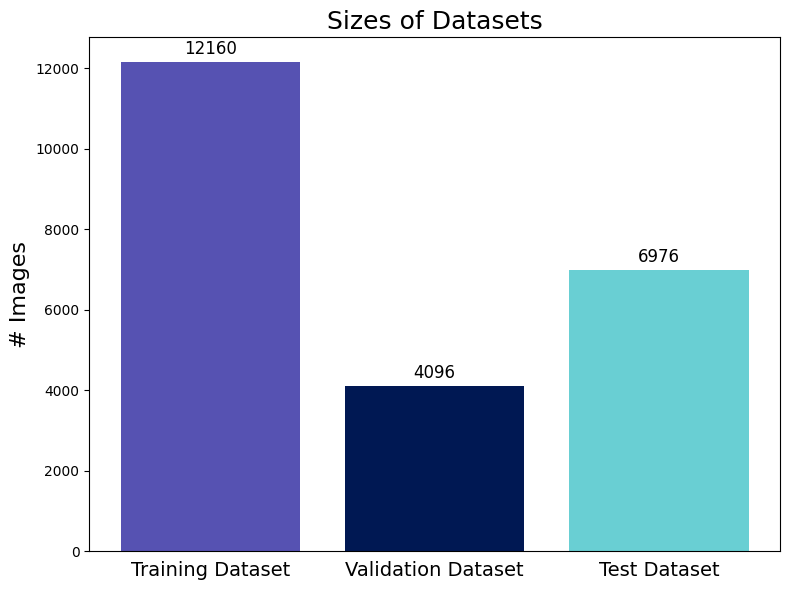

In [7]:
# Calculate the total number of images in each dataset
train_images = train_dataset.cardinality().numpy() * batch_size
validation_images = validation_dataset.cardinality().numpy() * batch_size
test_images = test_dataset.cardinality().numpy() * batch_size

# Set the labels and values for the bars
labels = ['Training Dataset', 'Validation Dataset', 'Test Dataset']
values = [train_images, validation_images, test_images]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the bar chart
b = ax.bar(labels, values, color=['#5652b2', '#001853', '#69cfd3'])

# Customize the plot
ax.set_ylabel('# Images', fontsize=16)
ax.set_title('Sizes of Datasets', fontsize=18)
ax.tick_params(bottom=False, left=True)
# Increase the font size of x-axis tick labels
ax.tick_params(axis='x', labelsize=14)

# Add text labels on top of the bars
for rect in b:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

#### Anzahl der Bilder pro Klasse

['end_speed', 'no_sign', 'speed_100', 'speed_120', 'speed_30', 'speed_40', 'speed_50', 'speed_70', 'speed_80']


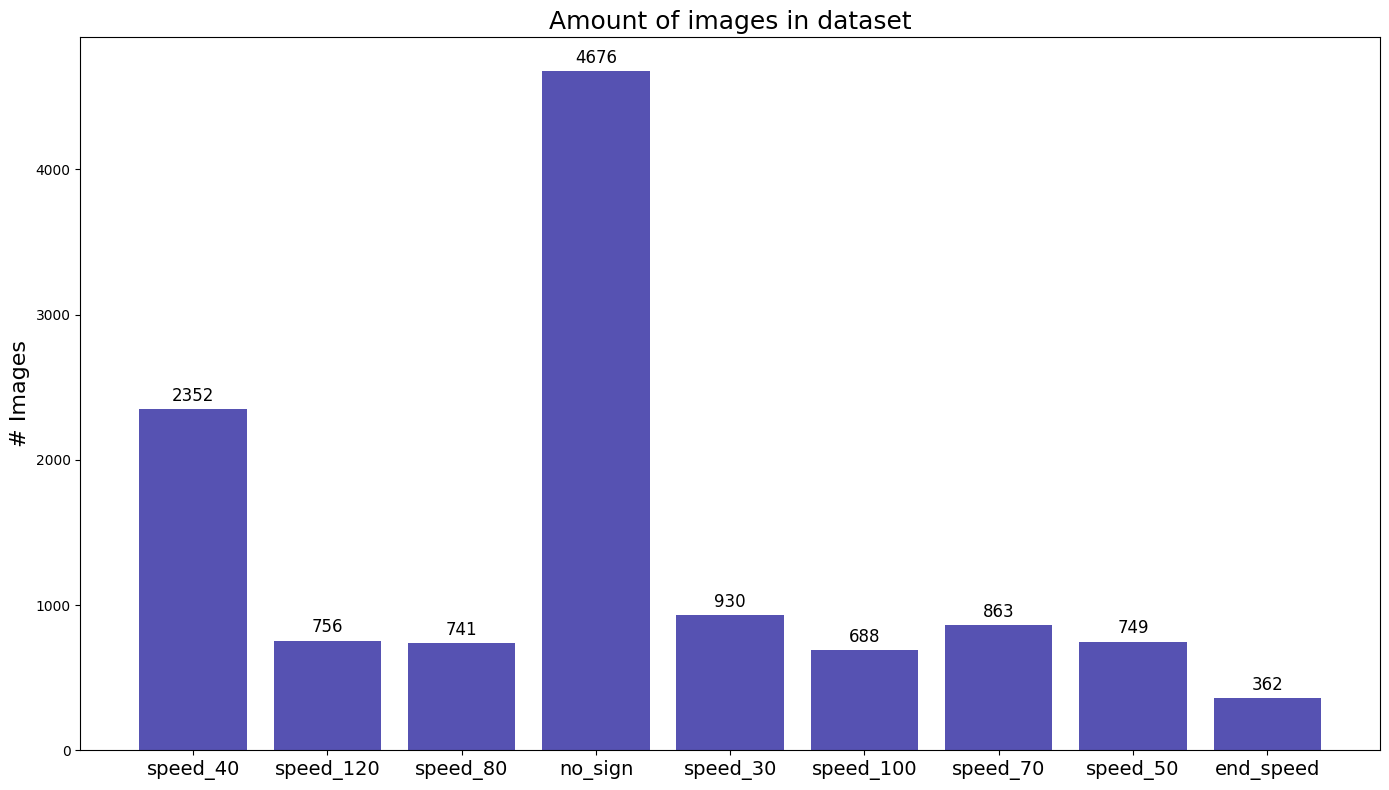

In [8]:
plot_class_names = train_dataset.class_names
print(class_names)

class_cnt_dict = {}

# Anzahl der Bilder pro Klasse im Trainingsdatensatz
class_counts = {}
for images, labels in train_dataset:
    for label in labels.numpy():
        class_idx = tf.argmax(label).numpy()
        class_name = train_dataset.class_names[class_idx]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
        class_cnt_dict[class_idx] = class_cnt_dict.get(class_idx, 0) + 1

# Diagramm für die Anzahl der Bilder pro Klasse
fig, ax = plt.subplots(figsize=(14, 8))

# Extrahieren der Klassen und zugehörigen Anzahlen
classes, counts = zip(*class_counts.items())
plot_class_names = list(classes)

b = ax.bar(plot_class_names, counts, color='#5652b2')

# Customize the plot
ax.set_ylabel('# Images', fontsize=16)
ax.set_title('Amount of images in dataset', fontsize=18)
ax.tick_params(bottom=True, left=True)
ax.set_xticks(class_names)
ax.set_xticklabels(class_names, fontsize=14, rotation=0, )

# Add text labels on top of the bars
for rect in b:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x()
    + rect.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
class_cnt_dict

{8: 4490,
 1: 28159,
 7: 5236,
 2: 4115,
 5: 14069,
 3: 4595,
 4: 5421,
 6: 4450,
 0: 2163}

#### Attention!
The classes are not distributed equally. When training the network will set more focus to the over represented classes. To avoid this, it is possible to set weight factors for the classes during training when the loss function is optimized.
So with the following code the factors for the classes are calculated based on their amount of samples:

In [9]:
from sklearn.utils import class_weight

labels = []
for images, labels_batch in train_dataset:
    labels.extend(labels_batch.numpy().argmax(axis=1).tolist())

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                classes=np.unique(labels),
                                                y=labels)

class_weights = dict(zip(np.unique(labels), class_weights))
print(class_names)
print(class_weights)

['end_speed', 'no_sign', 'speed_100', 'speed_120', 'speed_30', 'speed_40', 'speed_50', 'speed_70', 'speed_80']
{0: 3.7191528545119708, 1: 0.2879241516966068, 2: 1.9568798449612403, 3: 1.7808641975308641, 4: 1.4476702508960573, 5: 0.5724206349206349, 6: 1.7975077881619939, 7: 1.5600617999227502, 8: 1.8169140800719747}


In [10]:
keys_list = list(class_cnt_dict.values())
keys_list

[2352, 756, 741, 4676, 930, 688, 863, 749, 362]

##### Plot some of the images:

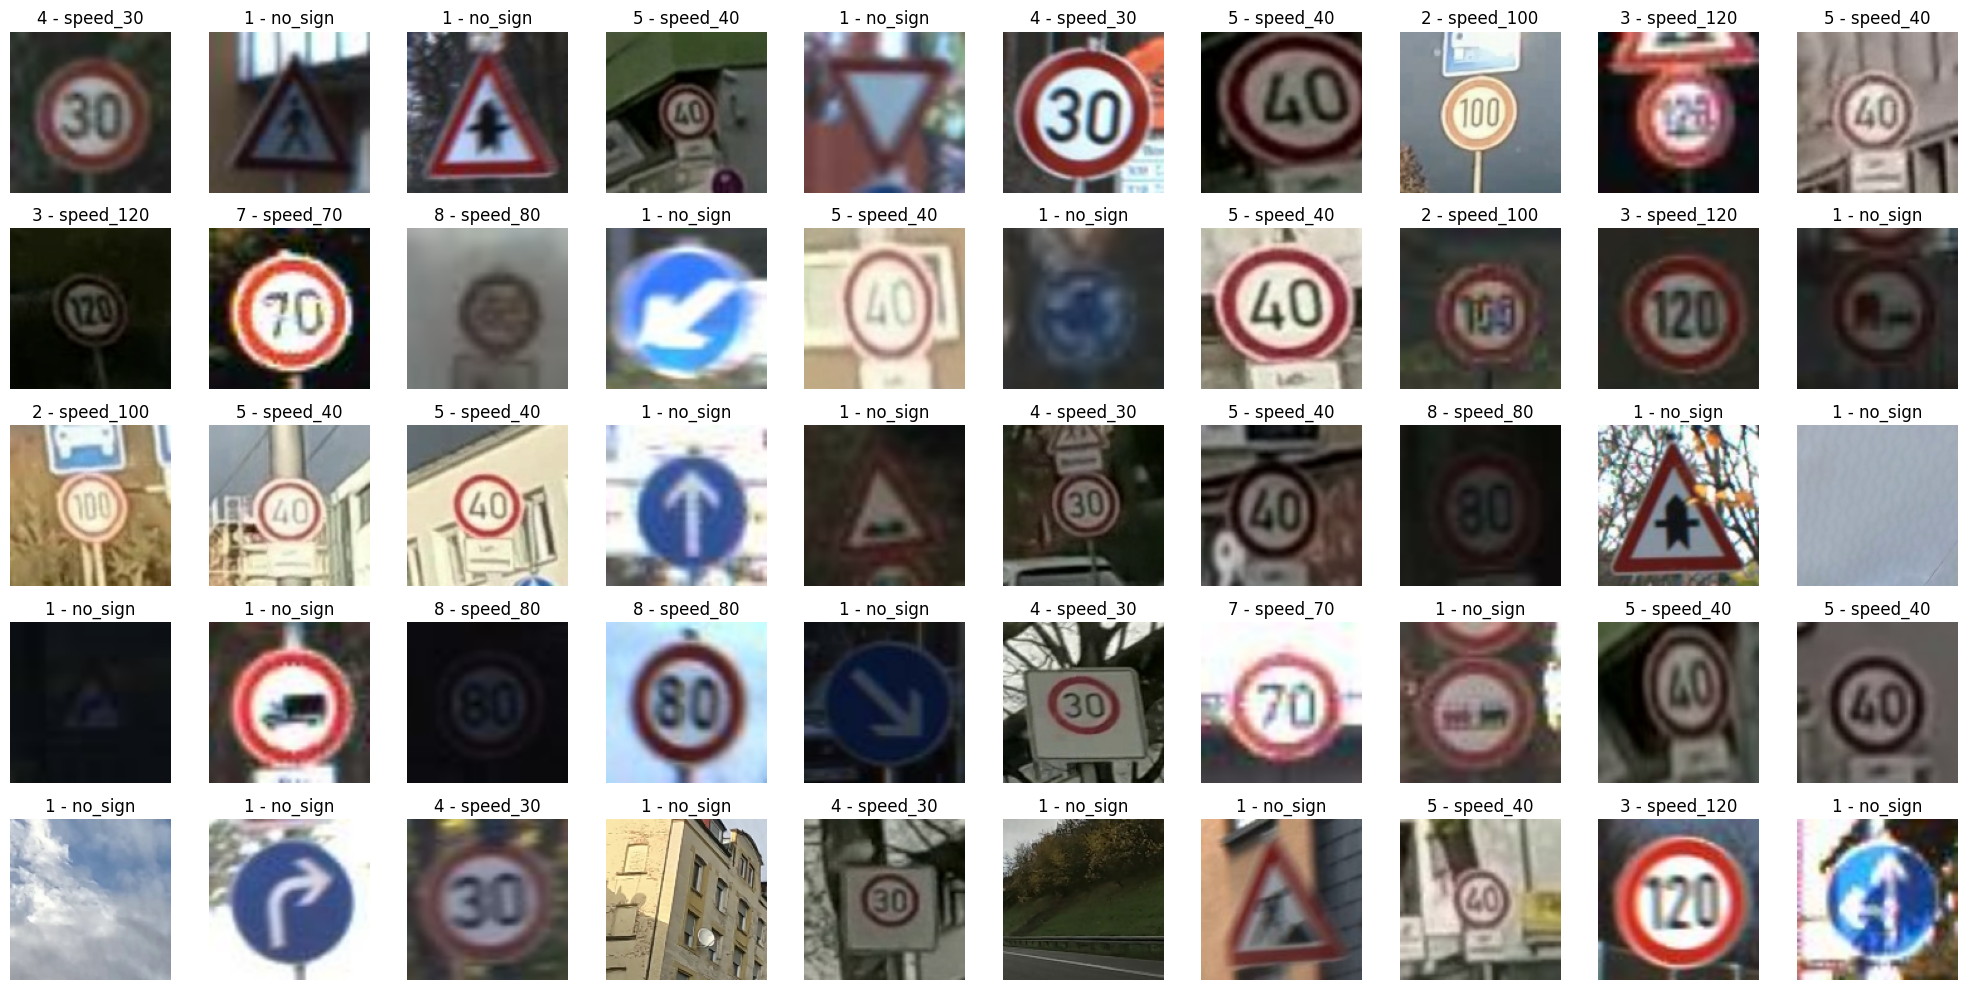

In [11]:
# Anzahl der Bilder, die Sie anzeigen möchten
num_images = 50

# Berechnen der Anzahl von Reihen und Spalten
num_rows = 5
num_cols = 10

plt.figure(figsize=(2 * num_cols, 2 * num_rows))
for images, labels in train_dataset.take(1):
    for i in range(num_images):
        if i >= len(images):
            break  # Verhindert einen Index-Fehler, falls weniger Bilder als num_images vorhanden sind
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i].numpy()) if isinstance(labels[i], tf.Tensor) else np.argmax(labels[i])
        plt.title(str(label_index) + ' - ' + train_dataset.class_names[label_index], fontsize=12)
        plt.axis("off")
plt.tight_layout()
plt.show()

Enable prefetching for faster batch processing

In [12]:
AUTOTUNE = tf.data.AUTOTUNE


train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Create own model

In [26]:
input_shape = (desired_height, desired_width, input_channels)

own_model_shallow = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),  # Rescaling-Schicht hinzufügen
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(number_of_classes, activation='softmax')  # Use softmax for multi-class classification
])


input_shape_test = (None, desired_height, desired_width, 3)  # None for the batch size, and 3 for the number of color channels
own_model_shallow.build(input_shape_test)
own_model_shallow.summary()
# Get the number of layers in the model
num_layers = len(own_model_shallow.layers)

print("Number of layers in the model:", num_layers)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_23 (Conv2D)          (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                 

In [17]:
# create callbacks by calling the previously defined functions
post_string = "_balanced"

checkpoint_callback = create_checkpoint('own_model_shallow'+ post_string)
earlystopping_callback = create_early_stopping(10)

#### Compile and train model

In [18]:
own_model_shallow.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # For multi-class classification
    metrics=['accuracy']
)

# evaluate the model on a batch of data from the test dataset
print("Evaluate on test data")
results = own_model_shallow.evaluate(test_dataset, batch_size=batch_size)

tf.keras.utils.plot_model(own_model_shallow, show_shapes=True)

Evaluate on test data


109/109 [==============================] - 4s 15ms/step - loss: 2.2338 - accuracy: 0.0582
Number of layers in the model: 11


In [82]:
# Record the start time
start_time = time.time()

history_own_model_shallow = own_model_shallow.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=100,
  callbacks=[
    checkpoint_callback,
    earlystopping_callback
    ],

  class_weight = class_weights
)

# Calculate the training time until training ends when validation accuracy doesn't increase anymore
training_time = time.time() - start_time

Epoch 1/100


216/217 [============================>.] - ETA: 0s - loss: 1.3020 - accuracy: 0.5597
Epoch 1: val_accuracy improved from -inf to 0.77508, saving model to models\own_model_shallow_balanced.h5
217/217 [==============================] - 9s 38ms/step - loss: 1.3015 - accuracy: 0.5599 - val_loss: 0.6920 - val_accuracy: 0.7751
Epoch 2/100
215/217 [============================>.] - ETA: 0s - loss: 0.3622 - accuracy: 0.8808
Epoch 2: val_accuracy improved from 0.77508 to 0.90488, saving model to models\own_model_shallow_balanced.h5
217/217 [==============================] - 9s 39ms/step - loss: 0.3615 - accuracy: 0.8811 - val_loss: 0.2970 - val_accuracy: 0.9049
Epoch 3/100
215/217 [============================>.] - ETA: 0s - loss: 0.1676 - accuracy: 0.9416
Epoch 3: val_accuracy improved from 0.90488 to 0.93478, saving model to models\own_model_shallow_balanced.h5
217/217 [==============================] - 9s 39ms/step - loss: 0.1668 - accuracy: 0.9419 - val_loss: 0.2464 - val_accuracy: 0.9348
E

##### Evaluate

Training time until best accuracy: 258.8946 seconds and 20 epochs
73/73 [==============================] - 1s 14ms/step - loss: 0.1690 - accuracy: 0.9788


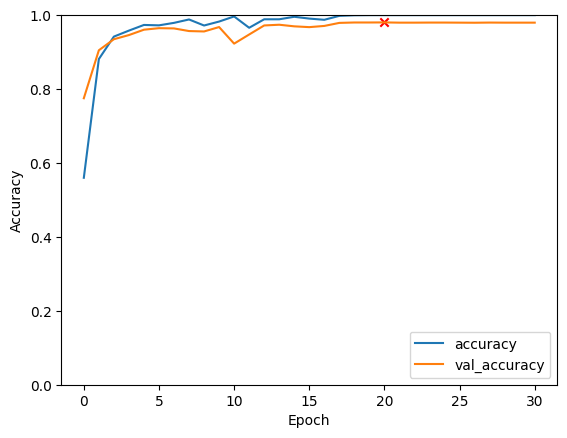

In [83]:
evaluate_model(history_own_model_shallow, 'own_model_shallow_balanced', training_time, test_dataset)

### Create a deeper model with more layers

In [25]:
desired_height, desired_width = 128, 128
input_shape = (desired_height, desired_width)

own_model_deeper = tf.keras.Sequential([
    tf.keras.layers.Resizing(desired_height, desired_width),  # Resizing layer
    tf.keras.layers.Rescaling(1./255),  # Rescaling-Schicht hinzufügen
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape, data_format='channels_last'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(number_of_classes, activation='softmax')  # Change to softmax for multi-class classification
])

input_shape_test = (None, desired_height, desired_width, 3)  # None for the batch size, and 3 for the number of color channels
own_model_deeper.build(input_shape_test)
own_model_deeper.summary()
# Get the number of layers in the model
num_layers = len(own_model_deeper.layers)

print("Number of layers in the model:", num_layers)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_5 (Resizing)       (None, 128, 128, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 64)       

In [22]:
# create callbacks by calling the previously defined functions
post_string = "_balanced"

checkpoint_callback = create_checkpoint('own_model_deeper'+post_string)
earlystopping_callback = create_early_stopping(10)

own_model_deeper.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])


  # Record the start time
start_time = time.time()

history_own_model_deeper = own_model_deeper.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=100,
  callbacks=[
    checkpoint_callback,
    earlystopping_callback
  ],
  class_weight = class_weights
)

# Calculate the training time until training ends when validation accuracy doesn't increase anymore
training_time = time.time() - start_time

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

Training time until best accuracy: 218.4685 seconds and 19 epochs
73/73 [==============================] - 1s 15ms/step - loss: 0.1085 - accuracy: 0.9840


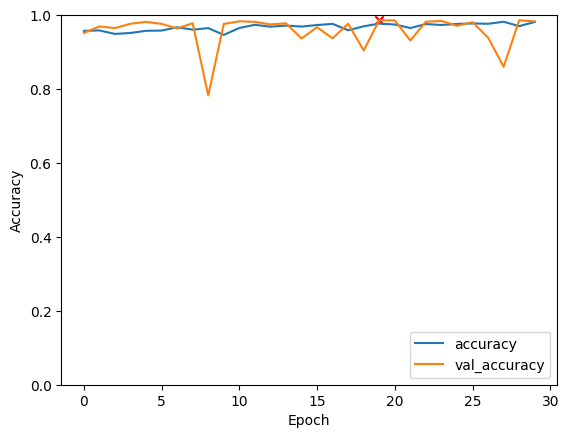

In [90]:
evaluate_model(history_own_model_deeper, 'own_model_deeper_balanced', training_time, test_dataset)

#### Use a pre-trained network - Transfer Learning

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (desired_width, desired_height) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classifier_activation="softmax",
                                               classes=len(class_names))


Preprocessing layer:

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Freeze or unfreeze the convolutional base

In [15]:
base_model.trainable = True
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

Add the classification head for sign classification

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# convert features to single 1280 element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# convert these features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(number_of_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(64, 4, 4, 1280)
(64, 1280)
(64, 9)


Build the model:
* add a resizing layer as the Network was trained on images with the size of 160x160

In [17]:
inputs = tf.keras.Input(shape=(128, 128, input_channels))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

input_shape_test = (None, desired_height, desired_width, 3)  # None for the batch size, and 3 for the number of color channels
model.build(input_shape_test)
# Get the number of layers in the model
num_layers = len(model.layers)

print("Number of layers in the model:", num_layers-1+base_model.layers.__len__())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

There are 158 layers trainable


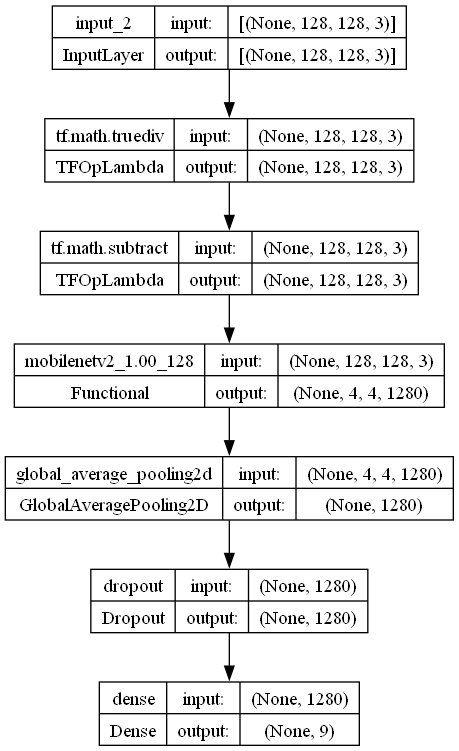

In [18]:
print(f"There are {len(model.trainable_variables)} layers trainable")
tf.keras.utils.plot_model(model, show_shapes=True)

Compile the model:

In [19]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])


First evaluate the model:

In [20]:
loss0, accuracy0 = model.evaluate(validation_dataset)
1
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


64/64 [==============================] - 3s 24ms/step - loss: 2.7169 - accuracy: 0.2749
initial loss: 2.72
initial accuracy: 0.27


The accuracy is expected. As there are 9 categories, the model just guesses one of them which is about 10-12% correct.

Now finetuning is done:

In [21]:
# create callbacks by calling the previously defined functions
post_string = "100k"

checkpoint_callback = create_checkpoint('MobileNet'+post_string)
earlystopping_callback = create_early_stopping(7)

# Record the start time
start_time = time.time()

history_mobilenet = model.fit(train_dataset,
                    epochs=140,
                    validation_data=validation_dataset,
                    callbacks=[
                    checkpoint_callback,
                    earlystopping_callback],
                    class_weight = class_weights
                    )

# Calculate the training time until training ends when validation accuracy doesn't increase anymore
training_time = time.time() - start_time

Epoch 1/140


190/190 [==============================] - ETA: 0s - loss: 0.9580 - accuracy: 0.6987
Epoch 1: val_accuracy improved from -inf to 0.92150, saving model to models\MobileNet100k.h5
190/190 [==============================] - 22s 90ms/step - loss: 0.9580 - accuracy: 0.6987 - val_loss: 0.2371 - val_accuracy: 0.9215
Epoch 2/140
189/190 [============================>.] - ETA: 0s - loss: 0.2375 - accuracy: 0.9313
Epoch 2: val_accuracy improved from 0.92150 to 0.96706, saving model to models\MobileNet100k.h5
190/190 [==============================] - 17s 87ms/step - loss: 0.2378 - accuracy: 0.9313 - val_loss: 0.1010 - val_accuracy: 0.9671
Epoch 3/140
189/190 [============================>.] - ETA: 0s - loss: 0.1509 - accuracy: 0.9572
Epoch 3: val_accuracy did not improve from 0.96706
190/190 [==============================] - 16s 85ms/step - loss: 0.1508 - accuracy: 0.9571 - val_loss: 0.1142 - val_accuracy: 0.9604
Epoch 4/140
189/190 [============================>.] - ETA: 0s - loss: 0.0981 - ac

### Load the saved models from disc if desired to make predictions

Training time until best accuracy: 447.9985 seconds and 19 epochs
109/109 [==============================] - 3s 24ms/step - loss: 0.0167 - accuracy: 0.9954


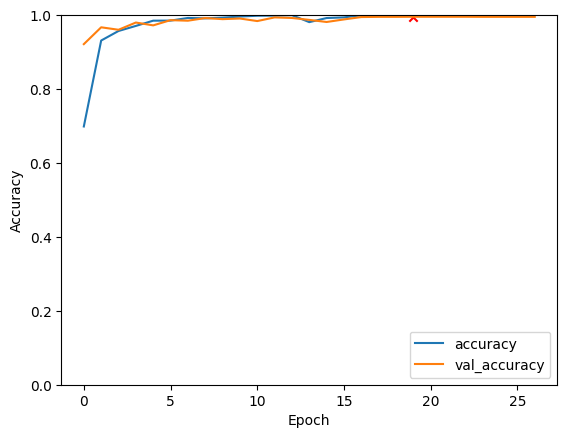

In [22]:
evaluate_model(history_mobilenet, 'MobileNet100k', training_time, test_dataset)

In [9]:
load_from_disc = True
own_model_shallow = None
own_model_deeper = None

if load_from_disc:
    model_path_shallow = os.path.join("models/", 'own_model_shallow.h5')
    model_path_deep = os.path.join("models/", 'own_model_deeper.h5')
    model_path_mobileNet = os.path.join("models/", 'MobileNet.h5')
    model_path_mobileNet60k = os.path.join("models/", 'MobileNet60k.h5')
    model_path_mobileNet100k = os.path.join("models/", 'MobileNet100k.h5')
    model_path_efficientNet60k = os.path.join("models/", 'EfficientNetB2_60k.h5')
    model_path_efficientNet100k = os.path.join("models/", 'EfficientNetB2_100k.h5')
    own_model_shallow = tf.keras.models.load_model(model_path_shallow)
    own_model_deeper = tf.keras.models.load_model(model_path_deep)
    own_model_mobileNet = tf.keras.models.load_model(model_path_mobileNet)
    own_model_mobileNet60k = tf.keras.models.load_model(model_path_mobileNet60k)
    own_model_mobileNet100k = tf.keras.models.load_model(model_path_mobileNet100k)
    own_model_efficientNet60k = tf.keras.models.load_model(model_path_efficientNet60k)
    own_model_efficientNet100k = tf.keras.models.load_model(model_path_efficientNet100k)


#### Create a confusion matrix each model by evaluating the test dataset

own_model_shallow:
109/109 [==============================] - 6s 16ms/step - loss: 0.0749 - accuracy: 0.9916
Loss: 0.0749
Accuracy: 0.9916
109/109 [==============================] - 2s 14ms/step
own_model_deeper:
109/109 [==============================] - 2s 15ms/step - loss: 0.0567 - accuracy: 0.9910
Loss: 0.0567
Accuracy: 0.9910
109/109 [==============================] - 2s 14ms/step
own_model_mobileNet:
109/109 [==============================] - 4s 22ms/step - loss: 0.0047 - accuracy: 0.9993
Loss: 0.0047
Accuracy: 0.9993
109/109 [==============================] - 3s 20ms/step
own_model_mobileNet60k:
109/109 [==============================] - 3s 21ms/step - loss: 0.0118 - accuracy: 0.9977
Loss: 0.0118
Accuracy: 0.9977
109/109 [==============================] - 3s 20ms/step
own_model_mobileNet100k:
109/109 [==============================] - 3s 23ms/step - loss: 0.0118 - accuracy: 0.9974
Loss: 0.0118
Accuracy: 0.9974
109/109 [==============================] - 3s 18ms/step
own_model_eff

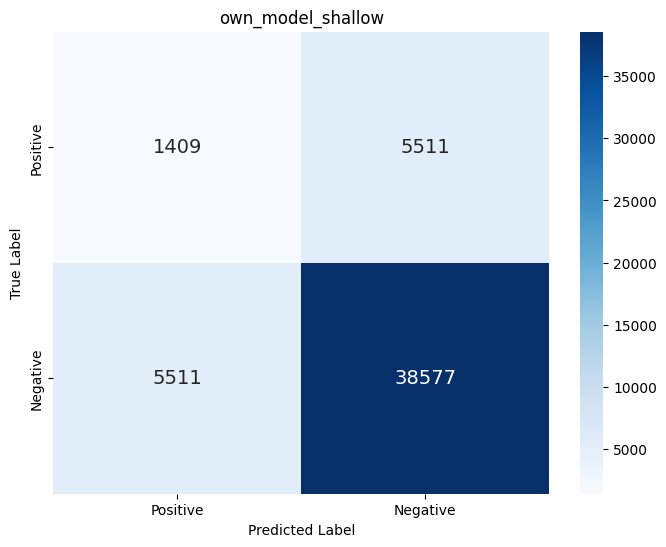

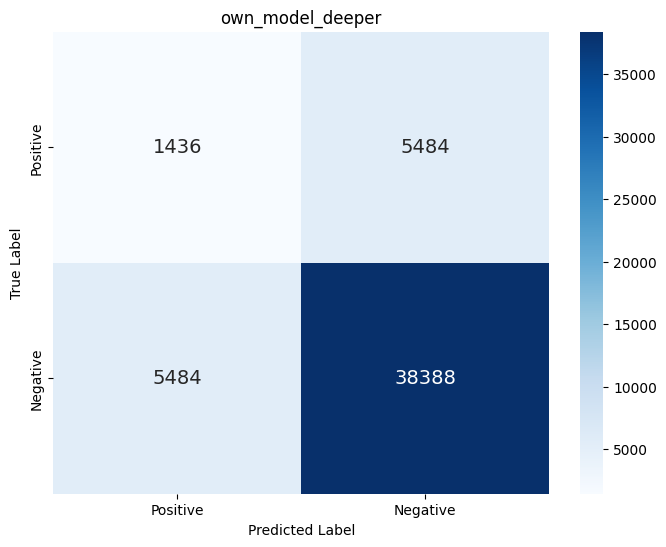

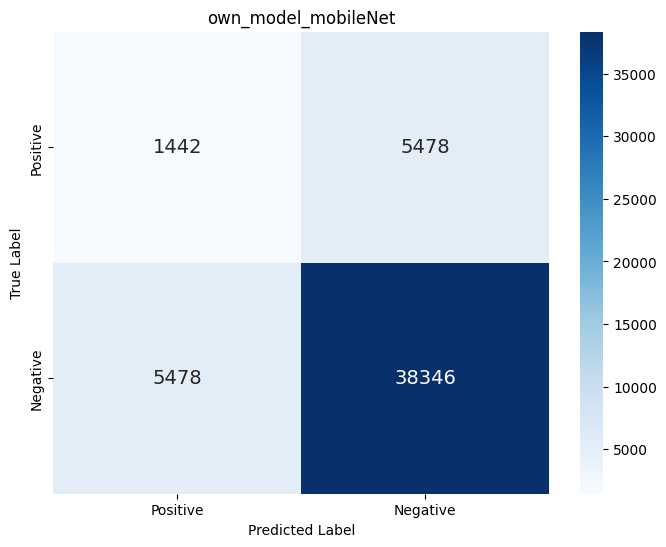

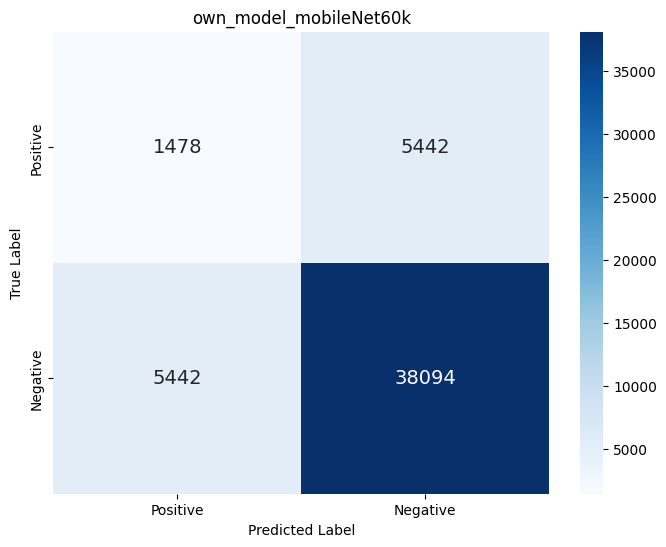

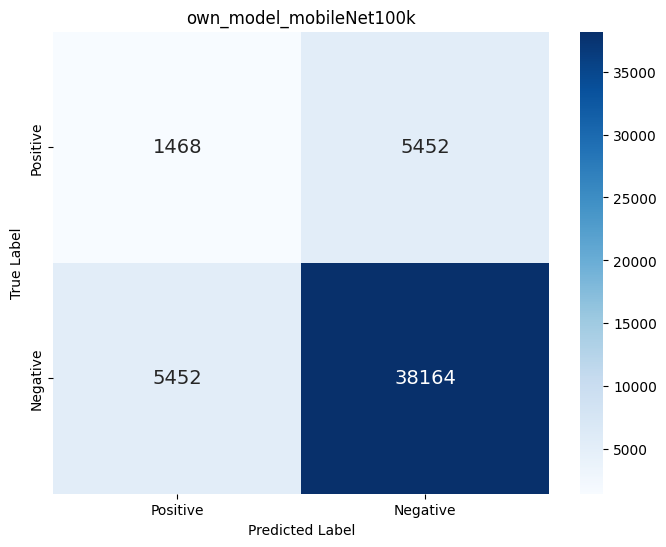

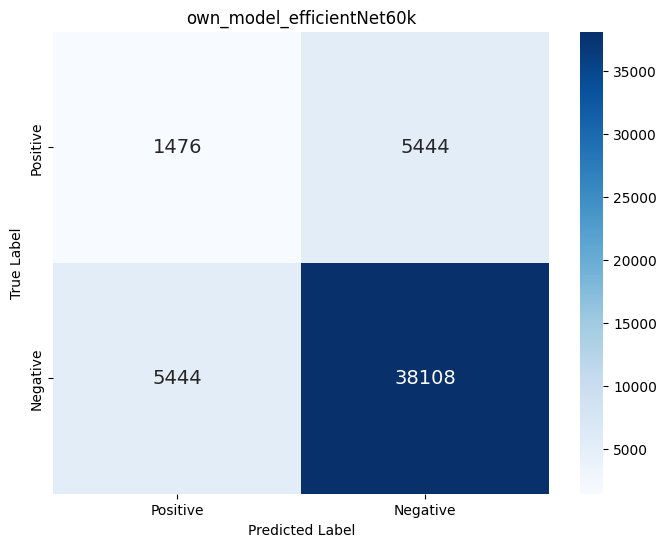

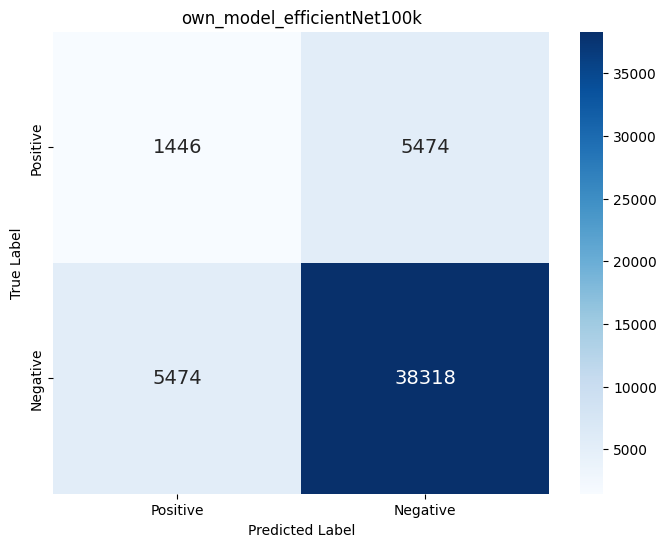

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to compute the confusion matrix and return TP, TN, FP, FN
def compute_confusion_matrix(model, test_dataset):
    # Get the predicted labels
    y_pred = model.predict(test_dataset).argmax(axis=1)
    # Get the true labels
    y_true = np.concatenate([y for x, y in test_dataset], axis=0).argmax(axis=1)
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Compute TP, TN, FP, FN
    TP = np.diag(cm).sum()
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    return TP, TN, FP.sum(), FN.sum()

# Evaluate and compute confusion matrix for each model
confusion_matrices = {}
for model_name, model in [('own_model_shallow', own_model_shallow),
                          ('own_model_deeper', own_model_deeper),
                          ('own_model_mobileNet', own_model_mobileNet),
                          ('own_model_mobileNet60k', own_model_mobileNet60k),
                          ('own_model_mobileNet100k', own_model_mobileNet100k),
                          ('own_model_efficientNet60k', own_model_efficientNet60k),
                          ('own_model_efficientNet100k', own_model_efficientNet100k)]:
    # Evaluate the model on the test dataset
    print(f'{model_name}:')
    loss, accuracy = model.evaluate(test_dataset)
    print(f'Loss: {loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    # Compute the confusion matrix
    TP, TN, FP, FN = compute_confusion_matrix(model, test_dataset)
    confusion_matrices[model_name] = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}

# Create a heatmap for each model
for model_name, metrics in confusion_matrices.items():
    # Ensure the metrics are single numbers
    TP = np.sum(metrics["TP"])
    TN = np.sum(metrics["TN"])
    FP = np.sum(metrics["FP"])
    FN = np.sum(metrics["FN"])
    # Create a 2x2 matrix of the metrics
    matrix = [[TP, FP],
              [FN, TN]]
    # Create a list of labels
    labels = ['Positive', 'Negative']
    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 14})
    plt.title(model_name)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

#### Measure the time required for one prediction

Avaialble classes: ['end_speed', 'no_sign', 'speed_100', 'speed_120', 'speed_30', 'speed_40', 'speed_50', 'speed_70', 'speed_80']
1/1 [==============================] - 0s 269ms/step
Average prediction time: 0.0011 seconds
Average probability of misclassified images: 0.9276


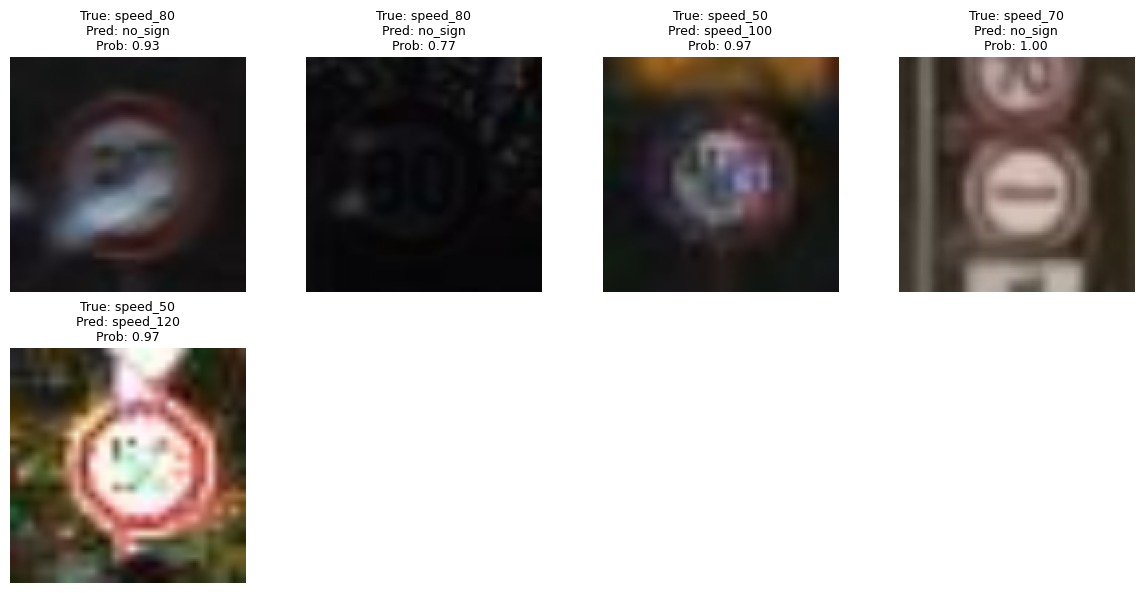

In [12]:
plot_misclassified_images_with_filenames(own_model_mobileNet, 100)

In [43]:
# image_path = r'C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision\test_video_results_MobileNet\tests\GX010093\rois\speed_40\frame_2243_speed_40_097_roi_429.jpg'
# #class_names = ['end_speed', 'no_sign', 'speed_100', 'speed_120', 'speed_30', 'speed_40', 'speed_50', 'speed_70', 'speed_80']
# # Load the image
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Add batch dimension to match the expected input shape (1, 128, 128, 1)
# input_data = np.expand_dims(image, axis=0)
# pred_probs = own_model_mobileNet(input_data)

# start_time = time.time()
# pred_probs = own_model_mobileNet(input_data)
# end_time = time.time()
# print(f"required time: {end_time-start_time}")

# print(class_names)
# print(pred_probs)
# pred_label = np.argmax(pred_probs)

# # Plotten der falsch klassifizierten Bilder

# plt.imshow(image)
# plt.title(f"Pred: {class_names[pred_label]}\nProb: {np.max(pred_probs):.2f}", fontsize=9)
# plt.axis("off")

# plt.tight_layout()
# plt.show()

In [44]:
# Pfad zum Ordner mit den Bildern
image_folder = r'C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision\datasets\sign_classification\error_test'
# image_folder = r"C:\Users\aaron\Desktop\Programmierung\Master\Machine Vision\Computer-Robot_Vision\datasets\sign_classification\test\speed_40"

# Liste der Klassennamen
class_names = ['end_speed', 'no_sign', 'speed_100', 'speed_120', 'speed_30', 'speed_40', 'speed_50', 'speed_70', 'speed_80']

# ... previous code ...

# Liste für die Bilder, Vorhersagen und tatsächlichen Klassen
images = []
pred_labels = []
true_labels = []

# Durchlaufen aller Bilder im Ordner
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Überprüfen, ob die Datei ein Bild ist
        # Pfad zum Bild
        image_path = os.path.join(image_folder, filename)

        # Laden des Bildes mit RGB-Farbraum
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        image = cv2.resize(image, (128, 128))

        # Hinzufügen der Batch-Dimension, um die erwartete Eingabeform zu erfüllen (1, 128, 128, 3)
        images.append(image)

        # Tatsächliche Klasse des Bildes (angenommen, der Klassenname ist im Dateinamen enthalten)
        true_label = 5
        true_labels.append(true_label)

# Umwandlung der Bilderliste in ein Numpy-Array
input_data = np.stack(images, axis=0)

print(input_data.shape)

# Vorhersage für alle Bilder
pred_probs = own_model_mobileNet.predict(input_data)
pred_labels = np.argmax(pred_probs, axis=1)

print(class_names)
# Berechnung der Genauigkeit
correct_predictions = sum(pred == true for pred, true in zip(pred_labels, true_labels))
accuracy = correct_predictions / len(true_labels)
print(f"Accuracy: {accuracy}")

(213, 128, 128, 3)
7/7 [==============================] - 1s 43ms/step
['end_speed', 'no_sign', 'speed_100', 'speed_120', 'speed_30', 'speed_40', 'speed_50', 'speed_70', 'speed_80']
Accuracy: 1.0


In [45]:
# # Lists for correct and incorrect predictions
# correct_predictions = []
# incorrect_predictions = []

# # Check which predictions were correct
# for i, (pred, true) in enumerate(zip(pred_labels, true_labels)):
#     if pred == true:
#         correct_predictions.append(i)
#     else:
#         incorrect_predictions.append(i)
# # Function to plot images
# def plot_images(indices, title):
#     n = len(indices)
#     nrows = n // 5 + (n % 5 > 0)  # Calculate the number of rows
#     fig, axs = plt.subplots(nrows, 5, figsize=(20, 4*nrows))  # Create a grid of subplots

#     for i, ax in zip(indices, axs.flatten()):
#         ax.imshow(images[i], )
#         ax.set_title(f"Predicted: {class_names[pred_labels[i]]}, Actual: {class_names[true_labels[i]]}")
#         ax.axis('off')  # Hide the axes

#     plt.suptitle(title, fontsize=16)
#     plt.tight_layout()
#     plt.show()

# # Plot incorrect predictions
# #plot_images(incorrect_predictions, "Incorrect Prediction")

# # Plot correct predictions
# #plot_images(correct_predictions, "Correct Prediction")

## Other Network Using Transfer Learning

Using the EfficientNetB2 (https://keras.io/api/applications/#finetune-inceptionv3-on-a-new-set-of-classes)

In [36]:
IMG_SHAPE = (desired_width, desired_height) + (3,)
B2_base_model = tf.keras.applications.EfficientNetV2B2(
                                                input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet',
                                                classifier_activation="softmax",
                                                classes=len(class_names))
B2_base_model.trainable = False

inputs = tf.keras.Input(IMG_SHAPE)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.

x = B2_base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x =  tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2, name="top_dropout")(x)
# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(9, activation='softmax', name="pred")(x)
B2_model = tf.keras.Model(inputs, outputs)

In [38]:
print(f"There are {len(B2_model.trainable_variables)} layers trainable")
tf.keras.utils.plot_model(B2_model, show_shapes=True)

input_shape_test = (None, desired_height, desired_width, 3)  # None for the batch size, and 3 for the number of color channels
B2_model.build(input_shape_test)
# Get the number of layers in the model
num_layers = len(B2_model.layers)

print("Number of layers in the model:", num_layers-1+B2_base_model.layers.__len__())

B2_model.summary()

There are 4 layers trainable
Number of layers in the model: 354
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetv2-b2 (Function  (None, 4, 4, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_18 (Bat  (None, 1408)             5632      
 chNormalization)                                                
                                                                 
 top_dropout (Dropout)       (None, 1408)              0     

In [48]:
# Compile
B2_model = tf.keras.Model(inputs, outputs, name="EfficientNetB2")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
B2_model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

First evaluation of model:

In [49]:
loss0, accuracy0 = B2_model.evaluate(validation_dataset)
1
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


379/379 [==============================] - 18s 38ms/step - loss: 2.2221 - accuracy: 0.1322
initial loss: 2.22
initial accuracy: 0.13


Now do first fine tuning on new top and input layers:

In [50]:
# create callbacks by calling the previously defined functions

checkpoint_callback = create_checkpoint('EfficientNetB2'+"_100k")
earlystopping_callback = create_early_stopping(5)

# Record the start time
start_time = time.time()

history_efficientNet = B2_model.fit(train_dataset,
                    epochs=15,
                    validation_data=validation_dataset,
                    callbacks=[
                    checkpoint_callback,
                    earlystopping_callback],
                    class_weight = {i: 1.0 for i in range(number_of_classes)}
                    )

# Calculate the training time until training ends when validation accuracy doesn't increase anymore
training_time = time.time() - start_time

Epoch 1/15


1136/1136 [==============================] - ETA: 0s - loss: 0.7176 - accuracy: 0.8149
Epoch 1: val_accuracy improved from -inf to 0.88057, saving model to models\EfficientNetB2_100k.h5
1136/1136 [==============================] - 63s 50ms/step - loss: 0.7176 - accuracy: 0.8149 - val_loss: 0.3993 - val_accuracy: 0.8806
Epoch 2/15
1136/1136 [==============================] - ETA: 0s - loss: 0.5018 - accuracy: 0.8455
Epoch 2: val_accuracy did not improve from 0.88057
1136/1136 [==============================] - 58s 51ms/step - loss: 0.5018 - accuracy: 0.8455 - val_loss: 0.3713 - val_accuracy: 0.8773
Epoch 3/15
1135/1136 [============================>.] - ETA: 0s - loss: 0.4909 - accuracy: 0.8446
Epoch 3: val_accuracy improved from 0.88057 to 0.88342, saving model to models\EfficientNetB2_100k.h5
1136/1136 [==============================] - 58s 51ms/step - loss: 0.4907 - accuracy: 0.8446 - val_loss: 0.3647 - val_accuracy: 0.8834
Epoch 4/15
1135/1136 [============================>.] - ETA:

Training time until best accuracy: 461.1599 seconds and 2 epochs
109/109 [==============================] - 6s 38ms/step - loss: 0.2893 - accuracy: 0.9061


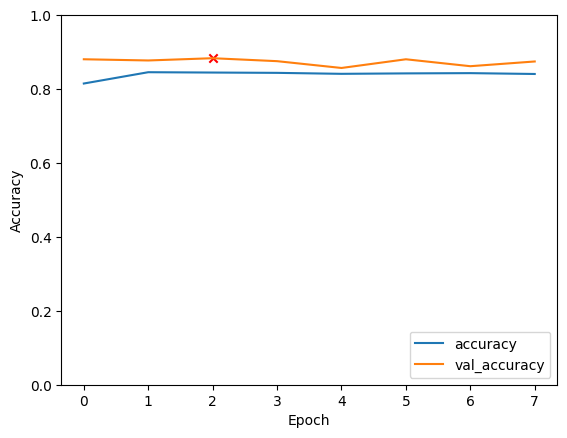

In [51]:
evaluate_model(history_efficientNet, 'EfficientNetB2_100k', training_time, test_dataset)

Next Step: Unfreeze a number of layers and fit the model using a smaller lerarning rate

In [52]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(B2_model)

Check if the layers are trainable

There are 312 layers trainable


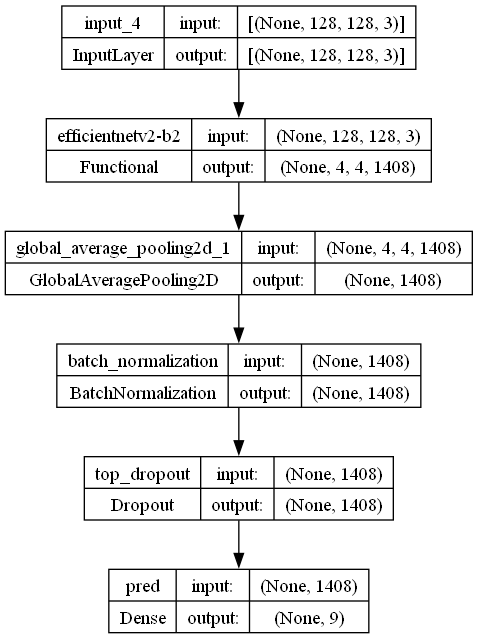

In [53]:
print(f"There are {len(B2_model.trainable_variables)} layers trainable")
tf.keras.utils.plot_model(B2_model, show_shapes=True)

Train the model again, this time only small steps are done but with all layers trainable

In [54]:
checkpoint_callback = create_checkpoint('EfficientNetB2'+"_100k")
earlystopping_callback = create_early_stopping(5)

# Record the start time
start_time = time.time()

history_efficientNet = B2_model.fit(train_dataset,
                    epochs=40,
                    validation_data=validation_dataset,
                    callbacks=[
                    checkpoint_callback,
                    earlystopping_callback],
                    class_weight = class_weights
                    )

# Calculate the training time until training ends when validation accuracy doesn't increase anymore
training_time = time.time() - start_time

Epoch 1/40


1136/1136 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.9272
Epoch 1: val_accuracy improved from -inf to 0.96905, saving model to models\EfficientNetB2_100k.h5
1136/1136 [==============================] - 209s 175ms/step - loss: 0.2758 - accuracy: 0.9272 - val_loss: 0.0940 - val_accuracy: 0.9690
Epoch 2/40
1136/1136 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9699
Epoch 2: val_accuracy improved from 0.96905 to 0.98221, saving model to models\EfficientNetB2_100k.h5
1136/1136 [==============================] - 198s 174ms/step - loss: 0.1028 - accuracy: 0.9699 - val_loss: 0.0534 - val_accuracy: 0.9822
Epoch 3/40
1136/1136 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9850
Epoch 3: val_accuracy improved from 0.98221 to 0.98960, saving model to models\EfficientNetB2_100k.h5
1136/1136 [==============================] - 196s 173ms/step - loss: 0.0473 - accuracy: 0.9850 - val_loss: 0.0319 - val_accuracy: 0.9896
Epo

Training time until best accuracy: 4159.6454 seconds and 16 epochs
109/109 [==============================] - 6s 35ms/step - loss: 0.0095 - accuracy: 0.9970


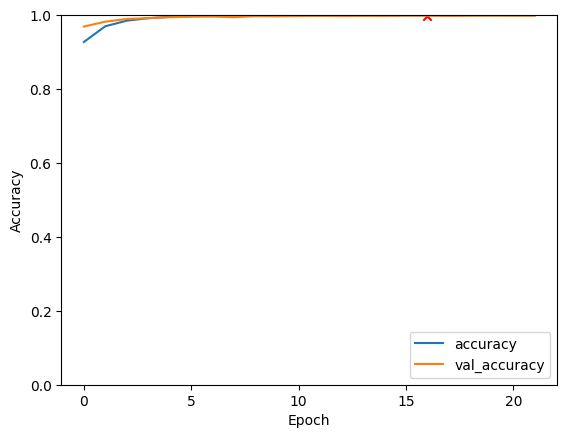

In [55]:
evaluate_model(history_efficientNet, 'EfficientNetB2_100k', training_time, test_dataset)


In [56]:
model_path_efficientNet = os.path.join("models/", 'EfficientNetB2_60k.h5')

model_efficientNet = tf.keras.models.load_model(model_path_efficientNet)

Avaialble classes: ['end_speed', 'no_sign', 'speed_100', 'speed_120', 'speed_30', 'speed_40', 'speed_50', 'speed_70', 'speed_80']
1/1 [==============================] - 0s 397ms/step
Average prediction time: 0.0018 seconds
Average probability of misclassified images: 0.8085


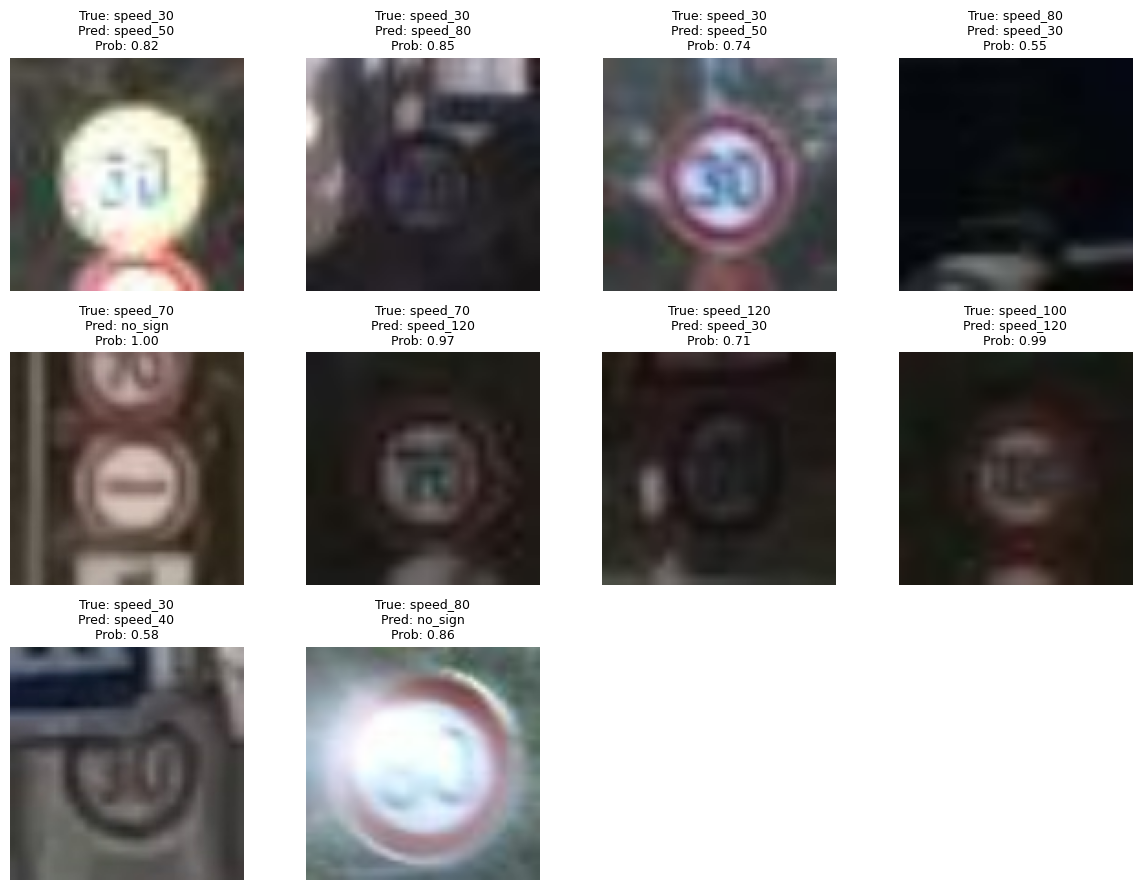

In [57]:
plot_misclassified_images_with_filenames(model_efficientNet, 100)